**Install Libraries**

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.2 MB/s 
     |████████████████████████████████| 7.6 MB 53.4 MB/s 
     |████████████████████████████████| 182 kB 72.9 MB/s 


**Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import re
import unicodedata
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
device = torch.device("cuda")

**Load Data**

In [3]:
df = pd.read_csv("/content/F2_Claim_Check_Worthiness_train.csv")
df.head()

,tweet,label,id
0,"India's gift of 100,000 COVID-19 vaccines arri...",0,0
1,As part of the ongoing nationwide vaccination ...,0,1
2,"Pleased to receive 50,000 doses of Covid-19 va...",0,2
3,Four former presidents have banded together fo...,0,3
4,WSJ: All three of Russia's main intelligence s...,1,4


In [4]:
test = pd.read_csv("/content/F2_Claim_Check_Worthiness_test.csv")
test.head()

,tweet,id
0,Native American communities have been hit hard...,0
1,ALERT: CVS Pharmacy is now offering COVID-19 v...,1
2,#COVID19 vaccines are an important tool to hel...,2
3,Pfizer reports that IRL the vaccine is 97% eff...,3
4,Vaccines are complex medicines. Europeans can ...,4


In [5]:
df.shape

(2122, 3)

In [6]:
df['label'].value_counts(normalize = True)

0    0.78935
1    0.21065
Name: label, dtype: float64

In [7]:
def clean_text(text):
  text = re.sub('\S*@\S*\s?', '', text)
  text = re.sub('\s+', ' ', text) 
  text = re.sub("\'", '', text)
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = re.sub('\s+[a-zA-Z]\s+^I', ' ', text)
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
  text = text.lower()
  return text

In [8]:
df['tweet'] = df['tweet'].apply(lambda x : clean_text(x)).values.tolist()
test['tweet'] = test['tweet'].apply(lambda x : clean_text(x)).values.tolist()

**split the data**

In [9]:
train_text, val_text, train_labels, val_labels = train_test_split(df['tweet'], df['label'], random_state=197,test_size=0.3,stratify=df['label'])

In [10]:
test_text=test['tweet']

In [11]:
test_text

0      native american communities have been hit hard...
1      alert cvs pharmacy is now offering covid vacci...
2      covid vaccines are an important tool to help s...
3      pfizer reports that irl the vaccine is effecti...
4      vaccines are complex medicines europeans can t...
                             ...                        
190    today university of pittsburgh school of medic...
191    uk coronavirus vaccine could be ready by septe...
192    top nih official anthony fauci says coronaviru...
193    my flintstones gummies from years ago fighting...
194    covid something we all need to be aware and al...
Name: tweet, Length: 195, dtype: object

In [12]:
tweets = [text for text in df.tweet]
max_len = 0
tweets_len = []
for tweet in tweets:
    tweets_len.append(len(tweet.split()))
    max_len = max(len(tweet.split()), max_len)

print('Number of tweets:', len(tweets))
print('Max length of the tweet:', max_len)
print('Mean length of the tweet:', np.mean(tweets_len))

Number of tweets: 2122
Max length of the tweet: 58
Mean length of the tweet: 38.13336475023563


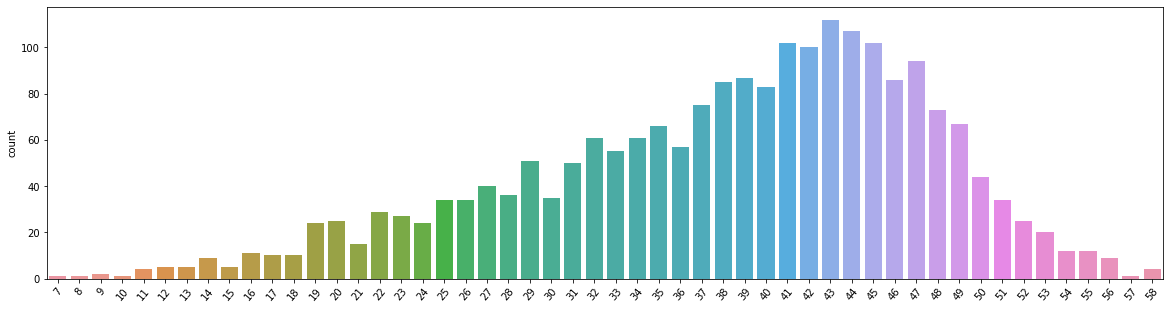

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
g = sns.countplot(x=tweets_len)
g.set_xticklabels(g.get_xticklabels(), rotation=50)
plt.show()

**Import BERT Tokenizer and Model**

In [14]:
from transformers import AutoModel, AutoTokenizer 

In [15]:
# bert = AutoModel.from_pretrained('roberta-base',return_dict=False)     
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [16]:
bert = AutoModel.from_pretrained('vinai/bertweet-covid19-base-uncased',return_dict=False)     
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-covid19-base-uncased")

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-covid19-base-uncased were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
# bert = AutoModel.from_pretrained('vinai/bertweet-large',return_dict=False)     
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

**Tokenization**

In [48]:
max_seq_len = 55

In [49]:
# tokenize and encode sequences 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

**Convert to Tensors**

In [50]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])


**DataLoaders**

In [51]:
batch_size = 16

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

**Freezing BERT Layers**

In [52]:
print(len(list((bert.named_parameters()))))

199


In [53]:
for name, param in list(bert.named_parameters())[:198]: 
  # print(name)
  param.requires_grad = False

**Model Architecture**

In [54]:
class BERT_fineTune(nn.Module):

    def __init__(self, bert):
      
      super(BERT_fineTune, self).__init__()
      self.bert = bert 
      self.relu =  nn.ReLU()
      # dropout layers
      self.dropout1 = nn.Dropout(0.1)
      self.dropout2 = nn.Dropout(0.2)
      #Linear Layers
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,128)
      self.fc3 = nn.Linear(128,2)
      # self.fc4 = nn.Linear(128,64)
      # self.fc5 = nn.Linear(64,16)
      # self.fc6 = nn.Linear(16,2)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      _, cls_hs = self.bert(sent_id, attention_mask=mask)    
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout1(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout1(x)
      x = self.fc3(x)
      x = self.softmax(x)
      return x

In [55]:
model = BERT_fineTune(bert)
model = model.to(device)

In [56]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(train_labels),y = train_labels)
class_weights_dict = dict(zip(np.unique(train_labels), class_weights))
class_wts=class_weights

In [57]:
optimizer = AdamW(model.parameters(), lr = 5e-5)
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights) 
epochs = 10

In [58]:
def train(): 
  model.train()
  total_loss, total_accuracy = 0.0, 0.0
  total_preds=[]
  for step,batch in enumerate(train_dataloader):    
    if step % 20 == 0 and not step == 0:   # progress update
      print('  Batch {:>5,}  of  {:>5,}'.format(step, len(train_dataloader)))
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch   
    model.zero_grad()    # clear previous calculated gradients     
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  total_preds = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [59]:
def evaluate(): 
  # print("Evaluating...")
  model.eval()
  total_loss, total_accuracy = 0.0, 0.0
  total_preds = []
  for step,batch in enumerate(val_dataloader):
    if step % 20 == 0 and not step == 0:  # Progress update
      print('  Batch {:>5,}  of  {:>5,}'.format(step, len(val_dataloader)))
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

**Model Training**

In [60]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]
for epoch in range(epochs):    
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train()
    valid_loss, _ = evaluate()   
    if valid_loss < best_valid_loss:  #save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'saved_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)   
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    20  of     93
  Batch    40  of     93
  Batch    60  of     93
  Batch    80  of     93
  Batch    20  of     40

Training Loss: 0.692
Validation Loss: 0.688

 Epoch 2 / 10
  Batch    20  of     93
  Batch    40  of     93
  Batch    60  of     93
  Batch    80  of     93
  Batch    20  of     40

Training Loss: 0.689
Validation Loss: 0.683

 Epoch 3 / 10
  Batch    20  of     93
  Batch    40  of     93
  Batch    60  of     93
  Batch    80  of     93
  Batch    20  of     40

Training Loss: 0.684
Validation Loss: 0.677

 Epoch 4 / 10
  Batch    20  of     93
  Batch    40  of     93
  Batch    60  of     93
  Batch    80  of     93
  Batch    20  of     40

Training Loss: 0.673
Validation Loss: 0.664

 Epoch 5 / 10
  Batch    20  of     93
  Batch    40  of     93
  Batch    60  of     93
  Batch    80  of     93
  Batch    20  of     40

Training Loss: 0.662
Validation Loss: 0.649

 Epoch 6 / 10
  Batch    20  of     93
  Batch    40  of     93
  Batch   

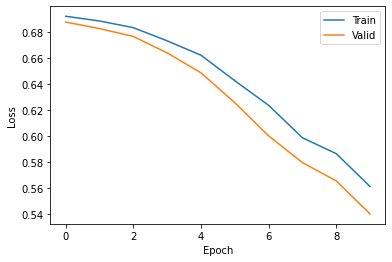

In [61]:
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [62]:
path = '/content/saved_weights.pt' 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Predictions for Test Data**

In [63]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
prediction = np.argmax(preds, axis = 1)

In [64]:
preds

array([[-0.22718258, -1.5934432 ],
       [-0.21904485, -1.6260029 ],
       [-0.24998794, -1.5087341 ],
       [-0.37253308, -1.1679204 ],
       [-0.3502401 , -1.2191504 ],
       [-0.32479054, -1.2825785 ],
       [-0.94957685, -0.48923486],
       [-0.22213759, -1.6134721 ],
       [-0.45604992, -1.0045269 ],
       [-0.2959202 , -1.3619797 ],
       [-0.5448345 , -0.8673525 ],
       [-0.36453694, -1.1858649 ],
       [-0.51544964, -0.9093946 ],
       [-0.5501932 , -0.86000115],
       [-0.52449405, -0.896132  ],
       [-0.2788707 , -1.4132043 ],
       [-0.11400625, -2.2279637 ],
       [-0.11078811, -2.255018  ],
       [-0.34596944, -1.2294073 ],
       [-0.9163083 , -0.51081395],
       [-0.32026857, -1.2944596 ],
       [-0.19489922, -1.73114   ],
       [-0.35203007, -1.2148955 ],
       [-0.18845534, -1.7616425 ],
       [-0.5488959 , -0.8617722 ],
       [-0.6119285 , -0.78155   ],
       [-0.61883473, -0.77342856],
       [-0.30996713, -1.3222725 ],
       [-0.3768708 ,

In [65]:
# preds
prediction

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [67]:
data = {'label': prediction,
        'id': test["id"]}

df_out = pd.DataFrame(data)
df_out.set_index('label', inplace=True)
df_out.to_csv('final_bertweet_pre.csv')

**References**

https://github.com/VinAIResearch/BERTweet 

https://github.com/wutonytt/Fake-News-Detection/blob/main/Balanced_Data.ipynb 

https://github.com/prathameshmahankal/Fake-News-Detection-Using-BERT/blob/main/notebooks/train.ipynb 

https://github.com/zhangyongheng78/COVID19-Fake-News-Detection-Using-BERT/blob/main/_Final_Submission_.ipynb